# Finding angles with gradient descent (projections & quaternions)

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors
import seaborn as sns; sns.set(style="white", color_codes=True)
import ipyvolume as ipv

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5466614301436155180
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15255946279406646341
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 888510485899424471
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3444310016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13613091781531297953
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
import pandas as pd

---

## Data

In [4]:
n_samples = 5000

In [5]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
dir_name = "../data/bgal/"
projections_filename = f"bgal_ProjectionsAngles_ProjNber5000_AngCoverage{angle_ranges}_AngShift{angle_shift}"
# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [6]:
# plot
all_vectors = RotationMatrix(data["Angles"])
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

##### Angles

###### Predicted Angles

In [7]:
# def clip_by_value(t, clip_value_min, clip_value_max,
#                   name=None):
#   """Clips tensor values to a specified min and max.
#   Given a tensor `t`, this operation returns a tensor of the same type and
#   shape as `t` with its values clipped to `clip_value_min` and `clip_value_max`.
#   Any values less than `clip_value_min` are set to `clip_value_min`. Any values
#   greater than `clip_value_max` are set to `clip_value_max`.
#   Note: `clip_value_min` needs to be smaller or equal to `clip_value_max` for
#   correct results.
#   For example:
#   ```python
#   A = tf.constant([[1, 20, 13], [3, 21, 13]])
#   B = tf.clip_by_value(A, clip_value_min=0, clip_value_max=3) # [[1, 3, 3],[3, 3, 3]]
#   C = tf.clip_by_value(A, clip_value_min=0., clip_value_max=3.) # throws `TypeError`
#   as input and clip_values are of different dtype
#   ```
#   Args:
#     t: A `Tensor` or `IndexedSlices`.
#     clip_value_min: A 0-D (scalar) `Tensor`, or a `Tensor` with the same shape
#       as `t`. The minimum value to clip by.
#     clip_value_max: A 0-D (scalar) `Tensor`, or a `Tensor` with the same shape
#       as `t`. The maximum value to clip by.
#     name: A name for the operation (optional).
#   Returns:
#     A clipped `Tensor` or `IndexedSlices`.
#   Raises:
#     ValueError: If the clip tensors would trigger array broadcasting
#       that would make the returned tensor larger than the input.
#     TypeError: If dtype of the input is `int32` and dtype of
#     the `clip_value_min' or `clip_value_max` is `float32`
#   """
#     with ops.name_scope(name, "clip_by_value",
#                       [t, clip_value_min, clip_value_max]) as name:
#         values = ops.convert_to_tensor(
#             t.values if isinstance(t, ops.IndexedSlices) else t, name="t")

#         # Go through list of tensors, for each value in each tensor clip
#         t_min = math_ops.minimum(values, clip_value_max)
#         # Assert that the shape is compatible with the initial shape,
#         # to prevent unintentional broadcasting.
#         _ = values.shape.merge_with(t_min.shape)

#         t_max = math_ops.maximum(t_min, clip_value_min, name=name)
#         _ = values.shape.merge_with(t_max.shape)

#         if isinstance(t, ops.IndexedSlices):
#             t_max = ops.IndexedSlices(t_max, t.indices, t.dense_shape)

#     return t_max

In [8]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(n_samples, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0001, 6.2831)


(5000,)

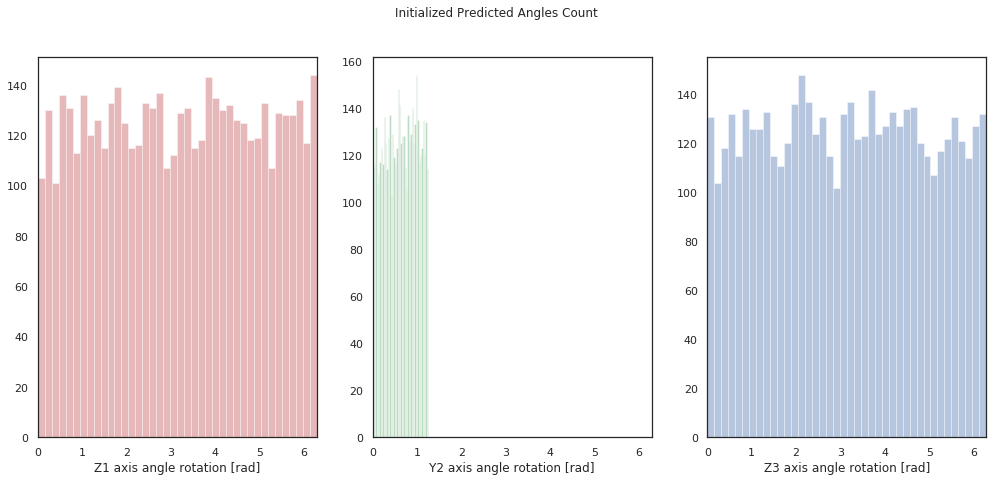

In [9]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Initialized Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

###### True Angles

In [10]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (0.0000, 6.2812)


(5000, 3)

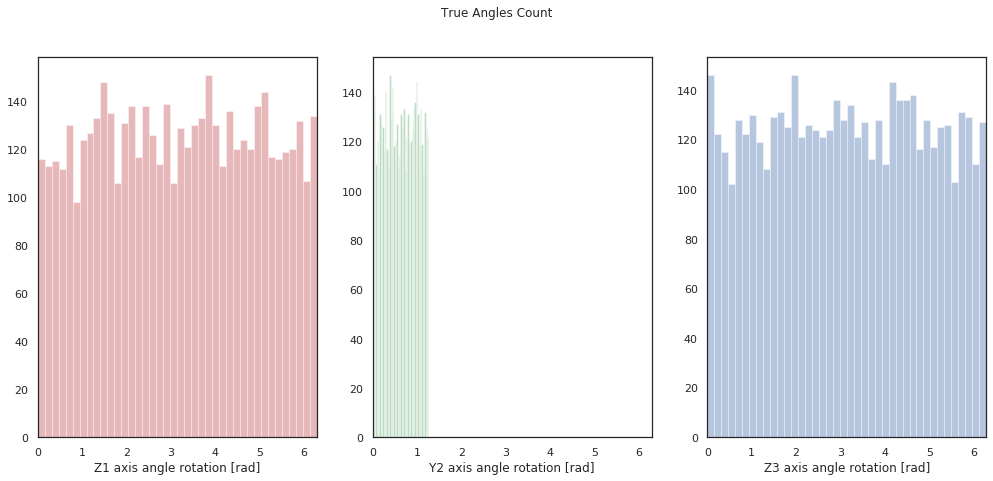

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(angles_true[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_true[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_true[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Projections

In [12]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
print(f"Projections: lenght = {len(projections)} (min, max) = ({np.min(projections):.4f}, {np.max(projections):.4f})")
projections = np.array(projections)

Projections: lenght = 5000 (min, max) = (0.0000, 22.7413)


---

## Distances

##### Angle Distances

In [13]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [14]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_true[:,0:5]), euler2quaternion(angles_true[:,0:5]))) < 1e-7

In [15]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_predicted[0:4]), euler2quaternion(angles_predicted[0:4]))) < 1e-7

In [16]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [17]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

---

## kNN of the Projections

In [18]:
# k = 5

In [19]:
# def get_knn_output(k):
#     start_time = time()

#     name = projections_filename.split('/')[-1]
#     if not os.path.exists(f'data/{name}_distances.npy'):
#         nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree', n_jobs=-1).fit(projections)
#         distances_p, indices_p = nbrs.kneighbors(projections)
#         A_p = nbrs.kneighbors_graph(projections).toarray()

#         try:
#             np.save(f'data/{name}_indices', indices_p)         # Indices of the nearest points in the population matrix
#             np.save(f'data/{name}_distances', distances_p)     # Array representing the lengths to points
#             np.save(f'data/{name}_A', A_p)                     # Sparse graph showing the connections between neighboring points
#         except:
#             pass
#         print(f"--- {time() - start_time} seconds ---")
    
#     else:
#         indices_p     = np.load(f'data/{name}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
#         distances_p   = np.load(f'data/{name}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
#         A_p           = np.load(f'data/{name}_A.npy')           # shape: NUM_IMGS, NUM_IMGS

    
#     return indices_p, distances_p, A_p 

In [20]:
# indices_p, distances_p, A_p = get_knn_output(k=k)

In [21]:
# np.max(distances_p)

---

## Compare d_Q and d_P

###### Slope & Intercept from kNN

In [22]:
# d_p_list = []
# d_q_list = []

# for indices in indices_p:
#     for jidx, j in enumerate(indices[1:], start=1):
#         i = indices[0]
        
#         # Get distance between 2 projections (already calculated in kNN)
#         distance_target_p = distances_p[i][jidx] 
#         # Collect projection distance for plotting
#         d_p_list.append(distance_target_p)

#         # Convert 2 angles to 2 corresponding quaternions
#         a1 = angles_true[i]
#         a2 = angles_true[j]
#         q1 = euler2quaternion(a1)
#         q2 = euler2quaternion(a2)
#         # Calculate the distance between 2 quaternions
#         distance_target_q = d_q(q1, q2)
#         # Collect quaternion distance for plotting
#         d_q_list.append(distance_target_q)

In [23]:
# # Creating the dataframe for SNS plot
# data = {"d_Q" : [x.numpy() for x in d_q_list],
#         "d_P" : d_p_list}
# df = pd.DataFrame(data=data)
# df = df[df.d_Q < 1.5]

In [24]:
# sns.jointplot(xlim=(0,np.pi), x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

In [25]:
# sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

In [26]:
# fig, ax = plt.subplots(1, 1, figsize=(17,10))
# g = sns.distplot(df["d_Q"], ax=ax);

# X=g.get_lines()[0].get_xdata()# x-coordinate of points along the regression line
# Y=g.get_lines()[0].get_ydata()# y-coordinate
# plt.plot(X, Y)

In [27]:
# df.describe()

In [28]:
# # dQ_mean = df.describe().iloc[1,0]
# # dP_mean = df.describe().iloc[1,1]
# # slope = dP_mean/dQ_mean
# # intercept = 0

# from scipy.stats import linregress
# lr = linregress(df.d_Q, df.d_P)
# slope, intercept = lr.slope, lr.intercept
# print(f"d_P/d_Q = {slope}, intercept = {intercept}")

#### Slope & Intercept from 1 compared to n

Collecting data for the plot where the result shows how 1 image changes distance in comparison to all the others. 

In [29]:
# # Plot convergence.
# all_q_dist = []
# all_p_dist = []
# time_start = time()

# d_q_list = []
# d_p_list = []

# # Take the first image
# i = 0

# # Sample some pairs.
# idx1 = list([i]*5000)
# idx2 = list(range(5000))

# # Compute distances between quaternions
# a1 = [angles_true[i] for i in idx1]
# a2 = [angles_true[i] for i in idx2]
# q1 = euler2quaternion(a1)
# q2 = euler2quaternion(a2)
# distance_target_q = d_q(q1, q2)
# d_q_list.append(distance_target_q)

# # Compute distances between projections
# p1 = [projections[i] for i in idx1]
# p2 = [projections[i] for i in idx2]
# distance_target_p = d_p(p1, p2)
# d_p_list.append(distance_target_p)

In [30]:
# plt.figure(figsize=(10,7))
# plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)   
# plt.xlabel('d_Q')
# plt.ylabel('d_P')

In [31]:
# # Creating the dataframe for SNS plot
# data = {"d_Q" : list(d_q_list[0].numpy()),
#         "d_P" : [x for x in d_p_list[0].numpy().T[0]]}
# df = pd.DataFrame(data=data)

In [32]:
# sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=7)  # "reg", "kde"

In [33]:
# slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df["d_Q"],df["d_P"])
# print(f"d_P/d_Q = {slope}, intercept = {intercept}")
# # dP = slope*dQ + intercept
# # => dQ = (dP-intercept)/slope

###### Slope & Intercept from m to all n

Collecting data for the plot where the result shows how several images change (m=10) distance in comparison to all the others. 

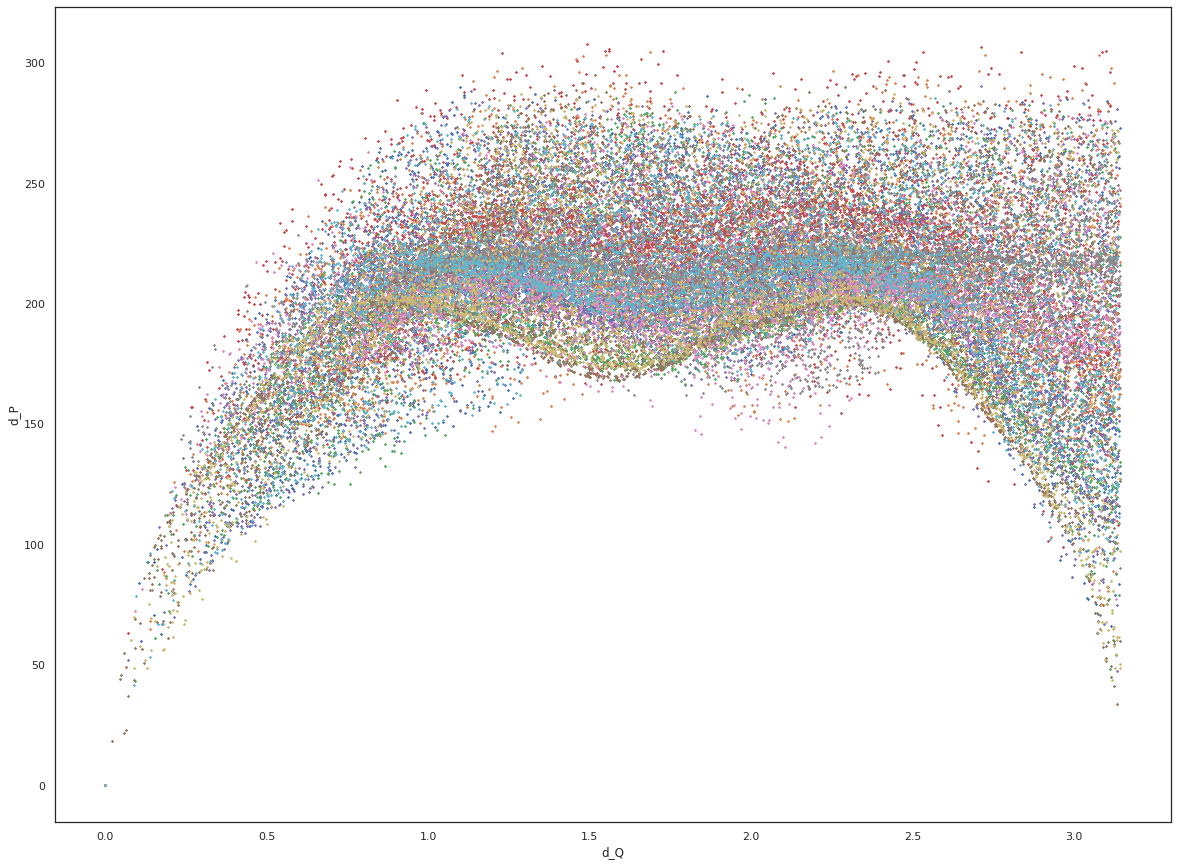

In [34]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

plt.figure(figsize=(20,15))

ITERATIONS = 5000

for i in range(0, ITERATIONS, 500):
    d_q_list = []
    d_p_list = []

    # Sample some pairs.
    idx1 = list([i]*5000)
    idx2 = list(range(5000))
    
    # Compute distances between quaternions
    a1 = [angles_true[i] for i in idx1]
    a2 = [angles_true[i] for i in idx2]
    q1 = euler2quaternion(a1)
    q2 = euler2quaternion(a2)
    distance_target_q = d_q(q1, q2)

    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    distance_target_p = d_p(p1, p2)

    all_q_dist.extend([x.numpy() for x in distance_target_q])
    all_p_dist.extend([x.numpy()[0] for x in distance_target_p])
    
    plt.plot(distance_target_q, distance_target_p, marker="*", markersize=2, lw=0)
    
plt.xlabel('d_Q')
plt.ylabel('d_P');

In [35]:
# Creating the dataframe for SNS plot
data = {"d_Q" : all_q_dist,
        "d_P" : all_p_dist}
df = pd.DataFrame(data=data)

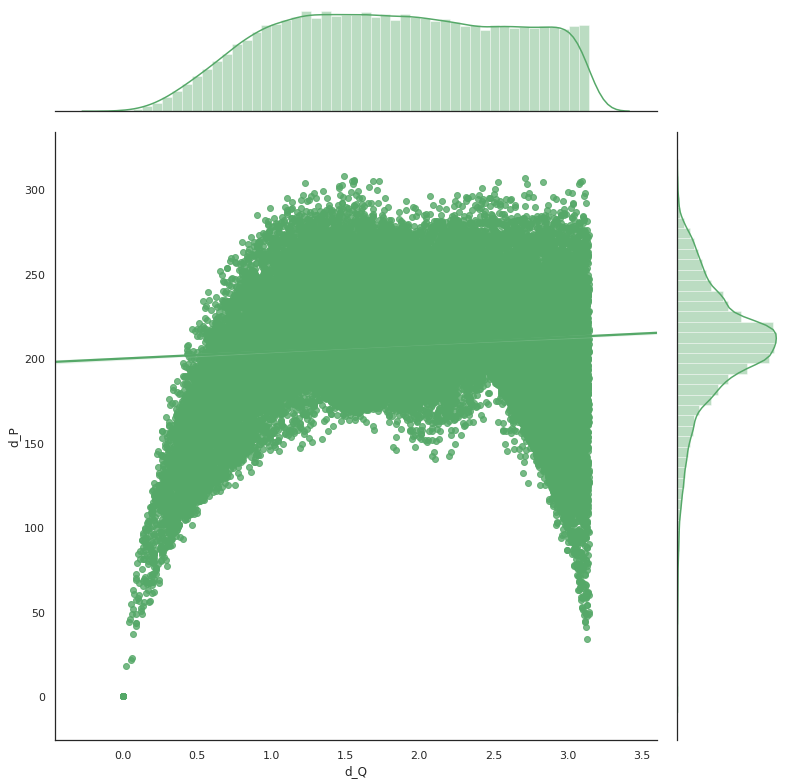

In [36]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11)  # "reg", "kde"

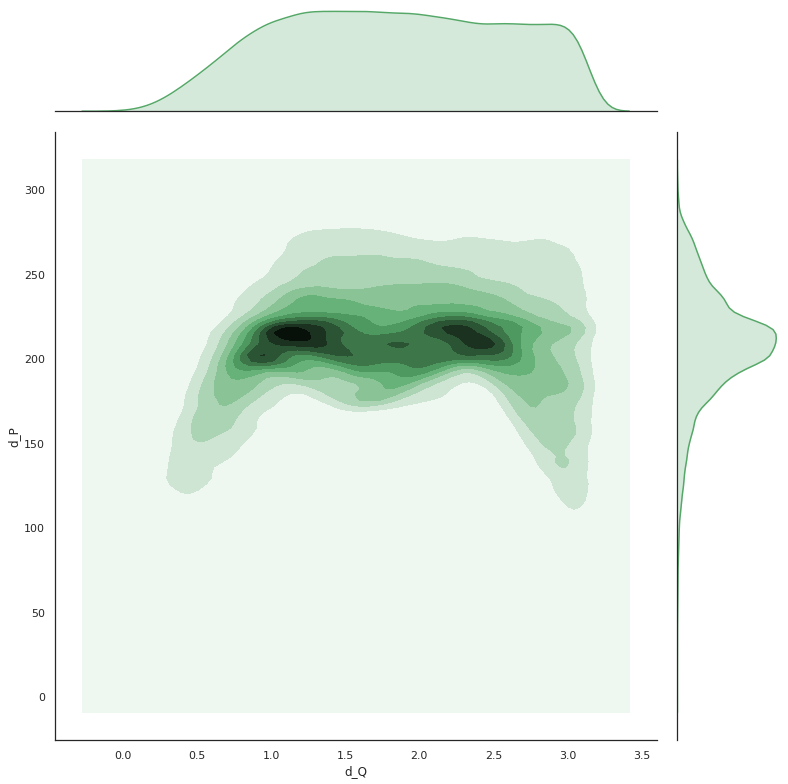

In [37]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)

###### Polyfit function

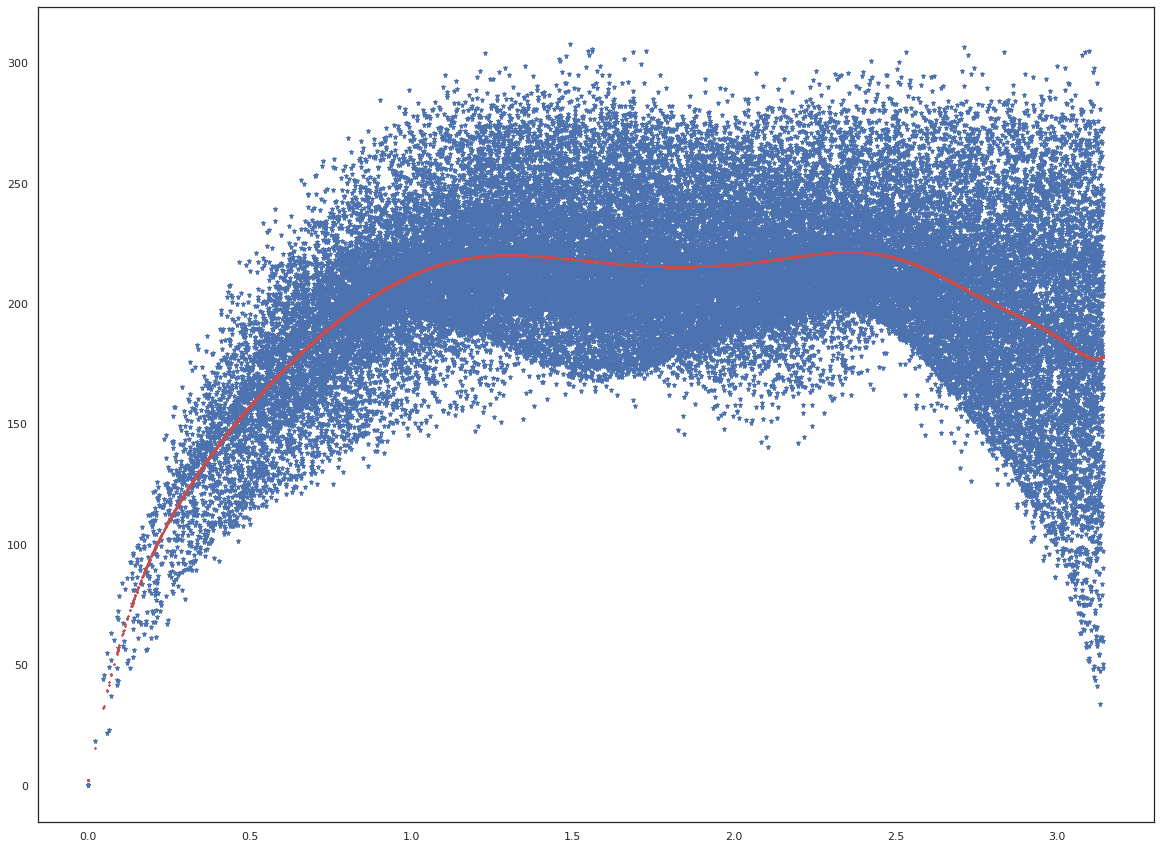

In [38]:
coeffs4dP = np.polyfit(df["d_Q"], df["d_P"], deg=14)
convert2dP = np.poly1d(coeffs4dP)

plt.figure(figsize=(20,15))
plt.plot(df["d_Q"], df["d_P"], marker="*", markersize=5, lw=0)
plt.plot(df["d_Q"], convert2dP(df["d_Q"]), marker="*", markersize=2, lw=0, c="r");

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [39]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [40]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

In [41]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")
    
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [angles_true[i] for i in idx1]
        a2_true = [angles_true[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [42]:
def sample_pairs(n_samples, batch_size, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
    
    elif style=="knn":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:batch_size//2]]
        idx2_random = list(np.random.randint(0, n_samples, batch_size//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

## Optimization loop (projection-true & angles-predict)

### [Before] Prediction vs. True Angles

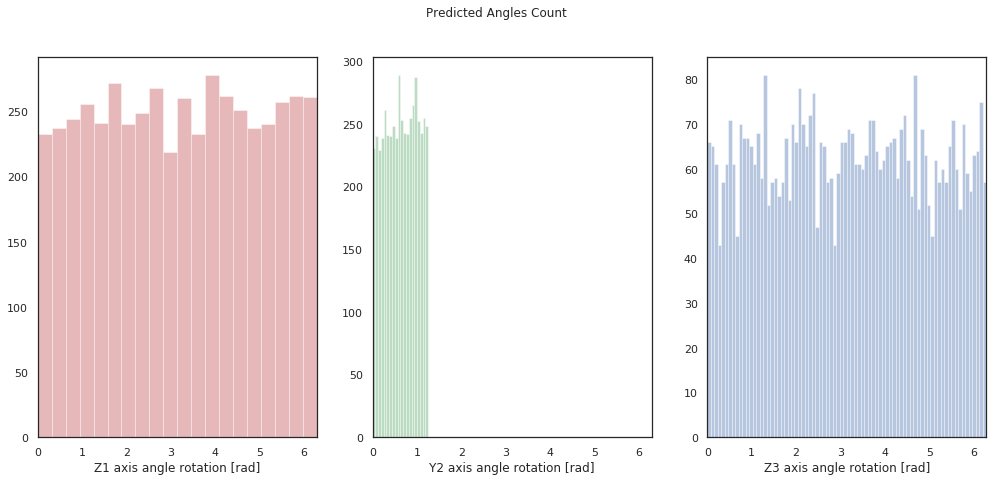

In [43]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [44]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (3s): loss = 1.10e+00
step 400/2000 (6s): loss = 1.06e+00
step 600/2000 (8s): loss = 1.06e+00
step 800/2000 (11s): loss = 1.26e+00
step 1000/2000 (14s): loss = 1.12e+00
step 1200/2000 (16s): loss = 1.09e+00
step 1400/2000 (19s): loss = 1.04e+00
step 1600/2000 (22s): loss = 1.09e+00
step 1800/2000 (25s): loss = 1.02e+00
step 2000/2000 (27s): loss = 1.00e+00
Mean loss: 1.0841129741400934


step 2000/20000 (1983s): loss = 1.67e+03
step 4000/20000 (3827s): loss = 1.62e+03
step 6000/20000 (5672s): loss = 1.44e+03
step 8000/20000 (7532s): loss = 1.66e+03
step 10000/20000 (9402s): loss = 1.99e+03
step 12000/20000 (11261s): loss = 1.76e+03
step 14000/20000 (13126s): loss = 1.42e+03
step 16000/20000 (14989s): loss = 1.49e+03
step 18000/20000 (16836s): loss = 1.68e+03
step 20000/20000 (18699s): loss = 1.86e+03


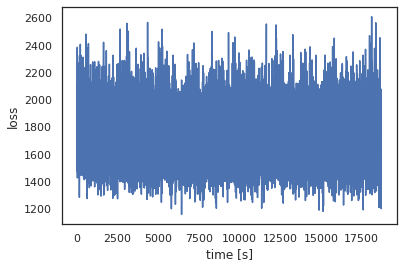

In [45]:
steps=20000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")
    
    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dPspace")
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

### [After] Prediction vs. True Angles

In [46]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 1.12e+00
step 400/2000 (5s): loss = 9.98e-01
step 600/2000 (7s): loss = 1.10e+00
step 800/2000 (10s): loss = 8.54e-01
step 1000/2000 (12s): loss = 1.14e+00
step 1200/2000 (15s): loss = 1.10e+00
step 1400/2000 (17s): loss = 1.11e+00
step 1600/2000 (19s): loss = 9.32e-01
step 1800/2000 (22s): loss = 1.10e+00
step 2000/2000 (24s): loss = 1.09e+00
Mean loss: 1.0689365213317472


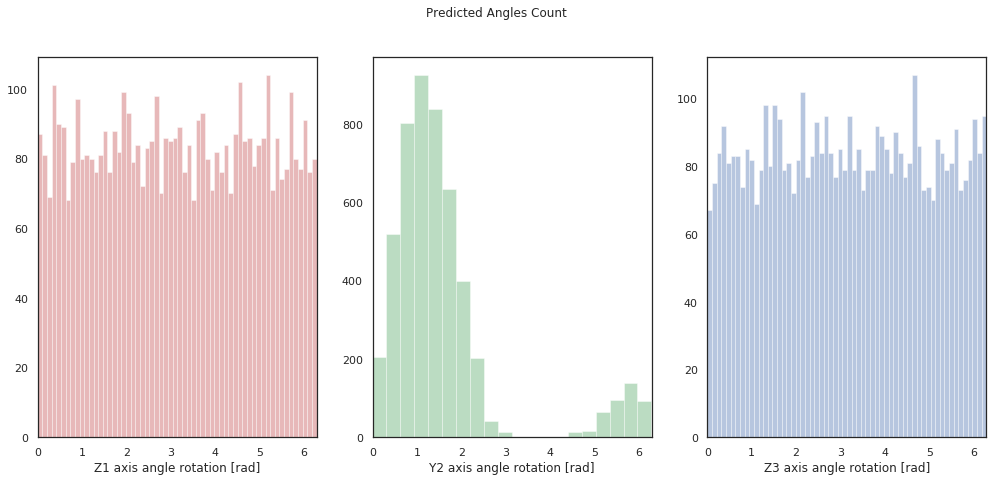

In [47]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=60, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=60, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [48]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/predicted_polyfit_30K_{angle_ranges}.html")
ipv.show()

---